In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, Loss, MS_SSIMLoss, PerceptualLoss
from csng.data import MixedBatchLoader
from csng.cat_v1.multireadin_decoder_all_data_utils import get_dataloaders

lt.monkey_patch()
DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
print(f"{DATA_PATH=}")

DATA_PATH='/home/sobotj11/decoding-brain-activity/data/cat_V1_spiking_model/50K_single_trial_dataset'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
    "wandb": None,
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


## Plot losses as a function of the amount of training data OR the number of neurons

In [3]:
import matplotlib as mpl
from csng.comparison import load_decoder_from_ckpt, get_metrics
from csng.cat_v1.comparison_utils import eval_decoder

In [17]:
### config
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "wandb": None,
    "wandb": {
        "project": "CSNG",
        "group": "cat_v1_50k",
    },
}

### cat v1 data
config["data"]["cat_v1"] = {
    "crop_win": (20, 20),
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 32,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 20.420,
        "resp_normalize_mean": torch.load(
            os.path.join(DATA_PATH, "responses_mean.pt")
        ),
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH, "responses_std.pt")
        ),
        # "training_sample_idxs": np.random.choice(45000, size=36000, replace=False),
    },
}

config["comparison"] = {
    "eval_all_ckpts": False,
    "load_best": True,
}

np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

In [19]:
runs = {
    ### amount of neurons
    # "2024-05-22_17-55-38": 0.5,
    # "2024-05-22_09-24-27": 1,
    # "2024-05-22_09-16-11": 2.5,
    # "2024-05-21_23-51-40": 5,
    # "2024-05-21_22-16-08": 10,
    # "2024-05-21_16-52-35": 20,
    # "2024-05-21_18-35-47": 40,
    # "2024-05-21_10-27-55": 60,
    # "2024-05-21_10-22-37": 80,
    # "2024-04-03_22-53-01": 100,

    ### amount of data
    "2024-05-22_19-15-11": 10,
    "2024-05-22_19-09-15": 20,
    "2024-05-22_19-11-28": 40,
    "2024-05-22_19-13-44": 60,
    "2024-05-22_21-55-52": 80,
    "2024-05-22_22-37-39": 100,
}
make_ckpt_path = lambda r_name: os.path.join(DATA_PATH, "models", "cnn", r_name, "decoder.pt")
metrics = get_metrics(crop_win=config["data"]["cat_v1"]["crop_win"], device=config["device"])

In [20]:
xs, ys = [], dict()

for r_name, val in runs.items():
    print(f"[INFO] Processing {r_name}...")
    ckpt_path = make_ckpt_path(r_name)
    decoder, ckpt = load_decoder_from_ckpt(ckpt_path=ckpt_path, device=config["device"], load_best=config["comparison"]["load_best"])
    dls, neuron_coords = get_dataloaders(config=config)
    test_losses = eval_decoder(
        model=decoder,
        dataloaders=dls["test"],
        loss_fns=metrics,
        config=config,
    )
    
    ### append for plotting
    xs.append(val)
    for l_name, losses in test_losses.items():
        if l_name not in ys:
            ys[l_name] = [losses["total"]]
        else:
            ys[l_name].append(losses["total"])

[INFO] Processing 2024-05-22_19-15-11...
[INFO] Processing 2024-05-22_19-09-15...
[INFO] Processing 2024-05-22_19-11-28...
[INFO] Processing 2024-05-22_19-13-44...
[INFO] Processing 2024-05-22_21-55-52...
[INFO] Processing 2024-05-22_22-37-39...


Text(0, 0.5, 'Perceptual loss')

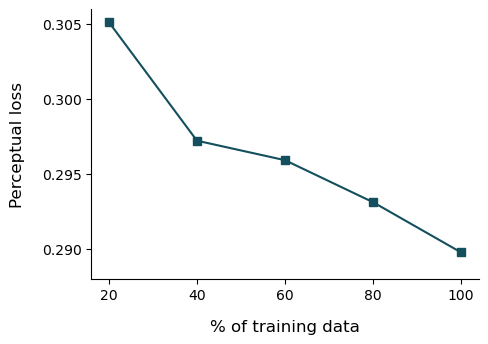

In [29]:
to_plot = "PL"

to_plot_label = to_plot
if to_plot == "PL":
    to_plot_label = "Perceptual loss"

fig, ax = plt.subplots(ncols=1, figsize=(5, 3.5))

ax.plot(xs, ys[to_plot], marker="s", color="#134f5cff")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(xs, fontsize=13)
ax.set_yticks(ax.get_yticks(), fontsize=12)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, min_n_ticks=2))
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, min_n_ticks=2))

# ax.set_xlabel("% of neurons", labelpad=12, fontsize=12)
ax.set_xlabel("% of training data", labelpad=12, fontsize=12)
ax.set_ylabel(to_plot_label, labelpad=12, fontsize=12)